In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


data = 'ecfp'
group_size = 1
num_exps = 120
num_repeats_per_exp = 1

policies = [
    # 'ens jensen greedy',
    # 'greedy',
    'classical ens',
    # 'round robin greedy',
]
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = '../../data/results/drug'


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'ecfp{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

OSError: ../../data/results/drug/ecfp88/1/classical ens/classical ens__labels__1.csv not found.

In [3]:
utilities[..., -1].mean(axis=(1, 2))

array([12.12626517, 10.27352871, 12.75680135])

In [4]:
utilities[..., -1].mean(axis=2)

array([[13.36915342, 10.6266705 , 12.3829716 ],
       [10.12862209, 11.96045001,  8.73151404],
       [16.04840718,  9.50282561, 12.71917127]])

ens jensen greedy: 12.1263
greedy: 10.2735
round robin greedy: 12.7568


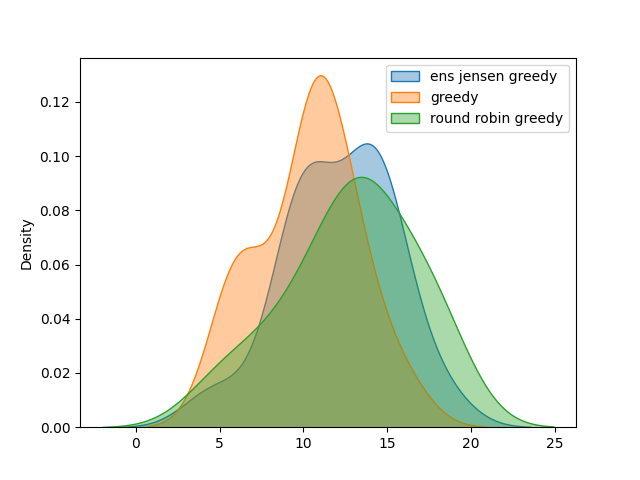

In [14]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, :, -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, :, :, -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend();

10.331624596087154 13.920905747696631
1.7946405758047383
8.637666578666 11.909390845218166
1.635862133276083
10.594459294139384 14.919143412507186
2.162342059183901


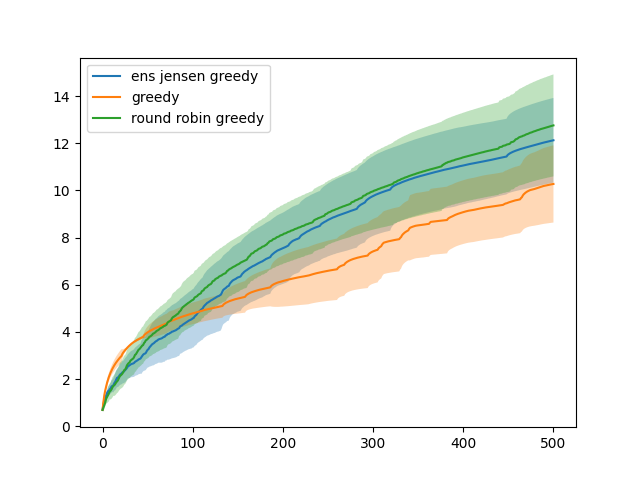

In [17]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(utilities[p_ind].mean(axis=(0, 1)), label=policy)
    lower, upper = DescrStatsW(utilities[p_ind].reshape(-1, budget + init_size)).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print((upper[-1] - lower[-1]) / 2)
    
plt.legend();